In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

## Wczytanie zbioru danych
Poniższy kod przygotowuje zbiór danych do przeprowadzenia treningu. Zostały przygotowane dwa scenariusze:

- A2D2
- Cityscapes

Odpowiedni zbiór wystarczy odkomentować w celu przeprowadzenia na nim treningu.

In [2]:
from transforms import *
from utils.encoding import ClassMappeer

from torchvision.datasets import Cityscapes
from datasets import A2D2Dataset

a2d2_root = ".\\data\\a2d2\\"
cityscapes_root = ".\\data\\cityscapes"

#A2D2

mapper = ClassMappeer(
    dataset_class=A2D2Dataset,
    train_transforms=transforms,
    infer_transforms=transforms_test,
    reduced_subset=True
    )

train_dataset = A2D2Dataset(
    root=a2d2_root,
    split='train',
    transforms=mapper.wrap_train
    
)

test_dataset = A2D2Dataset(
    root=a2d2_root,
    split='val',
    transforms=mapper.wrap_train
)

# Cityscapes

# mapper = ClassMappeer(
#     dataset_class=Cityscapes,
#     train_transforms=transforms,
#     infer_transforms=transforms_test,
#     reduced_subset=True
#     )

# train_dataset = Cityscapes(
#     root=cityscapes_root,
#     split='train',
#     target_type="semantic",
#     transforms=mapper.wrap_train
# )

# test_dataset = Cityscapes(
#     root=cityscapes_root,
#     split='val',
#     target_type="semantic",
#     transforms=mapper.wrap_train
# )

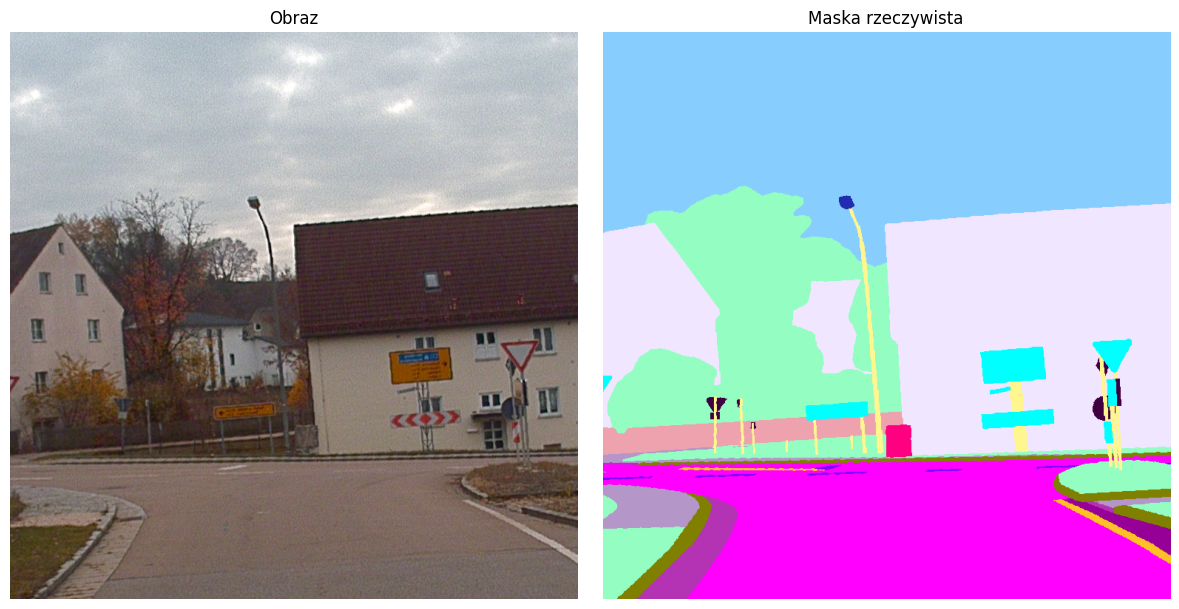

In [3]:
from utils.image import *

image, mask = test_dataset[5]

display_image_and_mask(image=image, mask_true=mask, mapper=mapper)

In [4]:
# Wyświetlanie widocznych na obrazie masek

classes = np.unique(mask)
names = {
    f'{mapper.mapping[int(cid)][1]}'
    for cid in classes
    if int(cid) in mapper.mapping
}
print("\n".join(names))

Curbstone
Sidewalk
RD restricted area
Painted driv. instr.
Dashed line
Poles
Traffic sign 1
Drivable cobblestone
RD normal street
Nature object
Obstacles / trash
Solid line
Irrelevant signs
Grid structure
Sky
Buildings
Signal corpus


In [5]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=12, 
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    drop_last=True
)

## Trening
Poniższy skrypt inicjalizuje model oraz rozpoczyna jego trening przy zadanych wartościach hiperparametrów.

In [ ]:
import pytorch_lightning as pl
import segmentation_models_pytorch as sm
from pytorch_lightning.loggers import CSVLogger

from models.unet import UnetModel

EPOCHS = 50
T_MAX = EPOCHS * len(train_loader)

model = UnetModel(
    encoder_weights="imagenet",
    encoder_name="resnext50_32x4d",
    in_channels=3,
    mapper=mapper
)

logger  = CSVLogger("logs", name="cityscapes") 
trainer = pl.Trainer(max_epochs=EPOCHS, logger=logger, precision=16)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params | Mode 
-----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Przykłady interferencji
Poniższy kod prezentuje przykłady interferencji.
- Interferencja na `test_dataset` z wyświetlaniem maski rzeczywistej.
- Interferencja na pojedyńczym obrazie ze zbioru testowego.
- Interferencja na własnym obrazie.

In [ ]:
import torch
from utils.image import *
from models.unet import UnetModel

# Załadowanie modelu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UnetModel.load_from_checkpoint(
    checkpoint_path=".\\logs\\cityscapes\\version_13\\checkpoints\\epoch=3-step=20028.ckpt",
    encoder_weights="imagenet",
    encoder_name="resnext50_32x4d",
    in_channels=3,
    mapping=mapper
)

model = model.to(device)

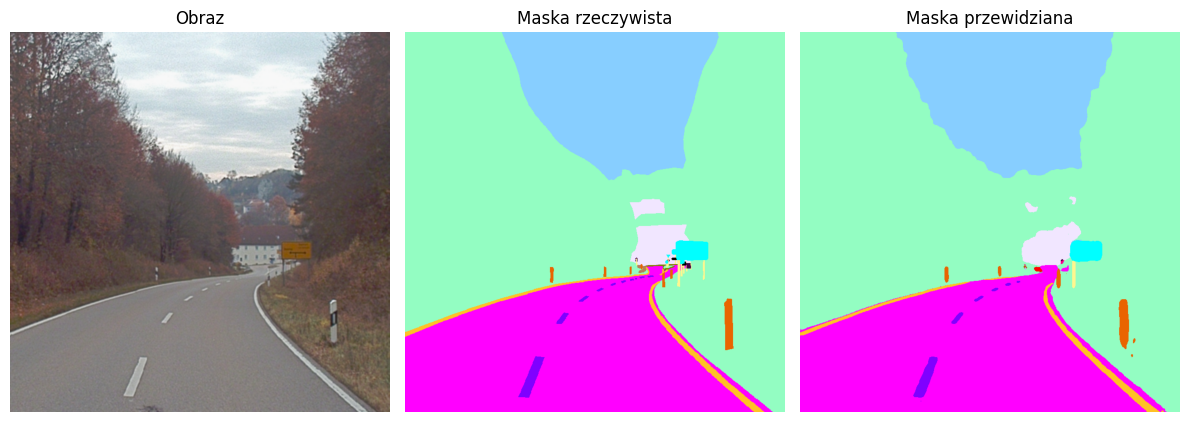

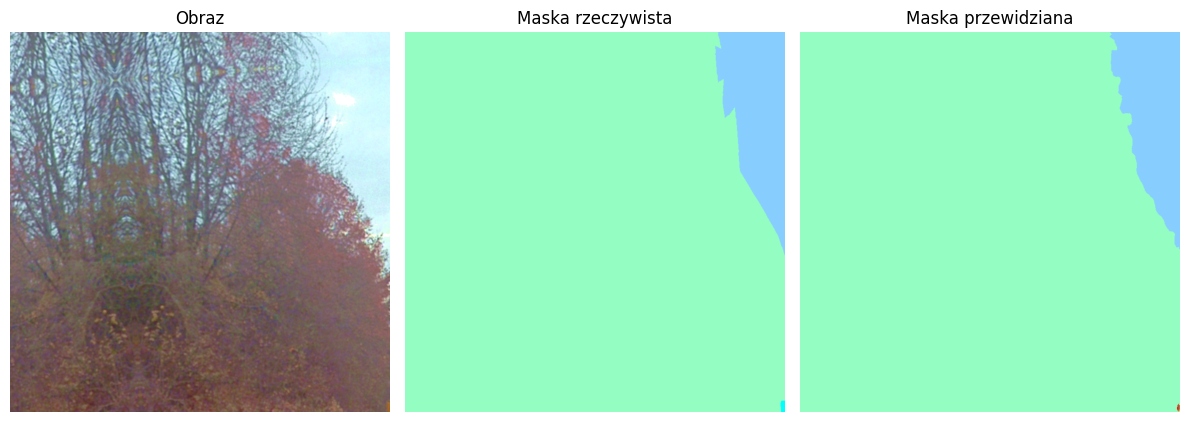

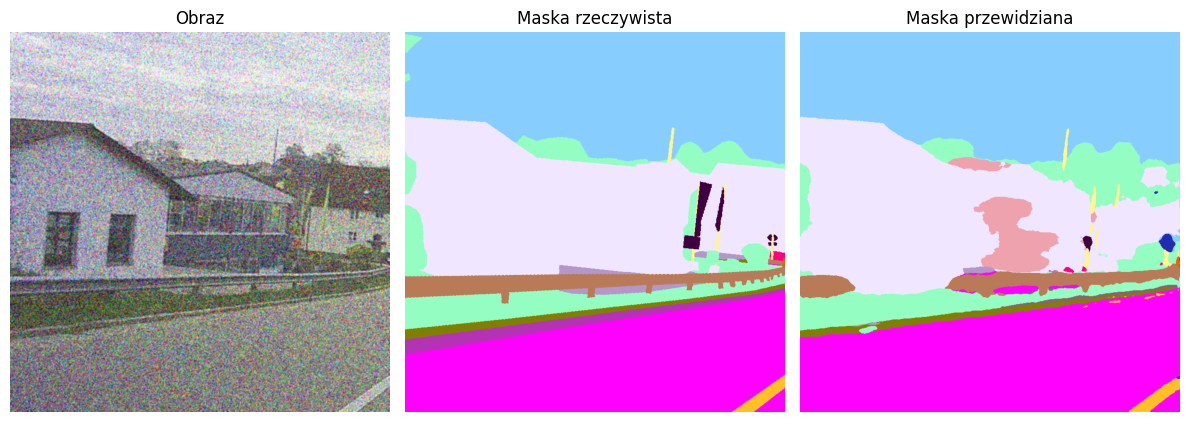

In [7]:
import torch
from utils.image import *

images, masks = next(iter(test_loader))
images = images.to(device)
masks  = masks.to(device)

masks = masks.squeeze(1)

with torch.inference_mode():
    model.eval()
    logits = model(images)

pr_masks = logits.softmax(dim=1).argmax(dim=1)

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx > 4:  # Visualize first 5 samples
        break

    img_cpu  = image.cpu().numpy().transpose(1,2,0)
    gt_cpu   = gt_mask.cpu().numpy()      # (H,W)
    pred_cpu = pr_mask.cpu().numpy()      # (H,W)

    display_image_and_mask(
        image=img_cpu,
        mask_true=gt_cpu,
        mask_pred=pred_cpu,
        mapper=mapper
    )

In [19]:
import torch
from torch.utils.data import DataLoader
from utils.image import *

# Test dataset loader
test_dataset = Cityscapes(
    root=cityscapes_root,
    split='test',
    target_type="semantic",
    transforms=mapper.wrap_infer
)

single_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

# Inference

images, _ = next(iter(single_loader))
images = images.to(device)

with torch.inference_mode():
    logits = model(images)

pr_masks = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=images[0], 
    mask_pred=pr_masks[0], 
    mapper=mapper
)


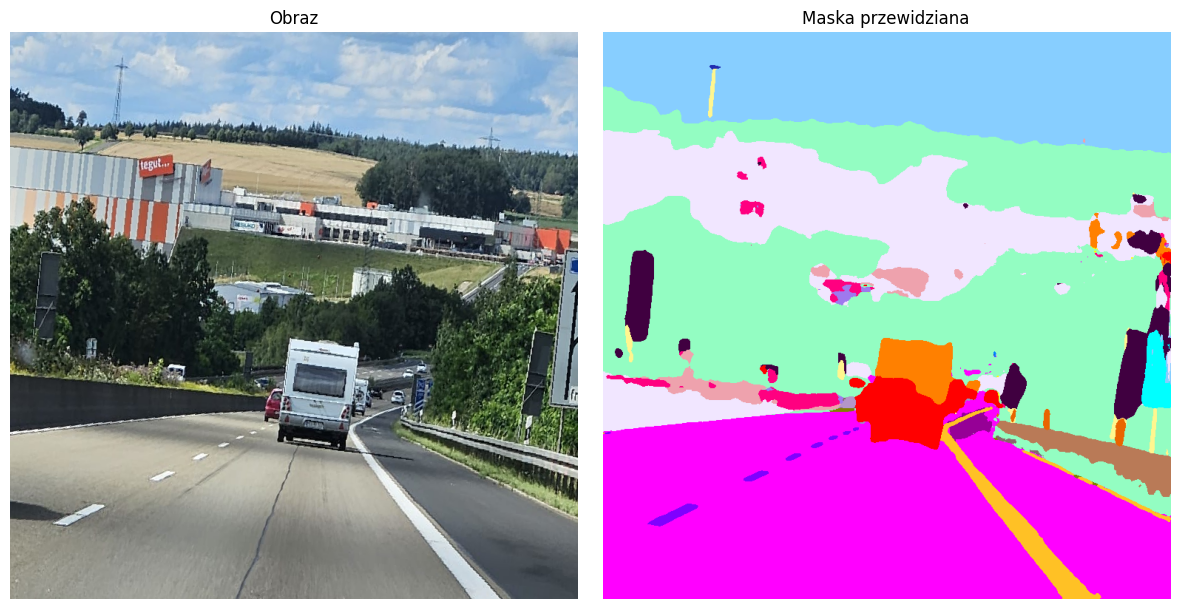

In [17]:
import torch
from PIL import Image
from utils.image import *

# Inference

pil_image = Image.open(r".\test\test2.png")

aug_image = mapper.preprocess_image(img=np.asarray(pil_image))
tensor_image = aug_image.to(device)

with torch.inference_mode():
    logits = model(tensor_image)
    
pr_mask = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=tensor_image, 
    mask_pred=pr_mask, 
    mapper=mapper
)